## Задание

Метрика:
- R2 - коэффициент детерминации (sklearn.metrics.r2_score)
- R2 > 0.6 на Private Leaderboard.
- Укажите свой ник на kaggle 

## 1. Подключение необходимых библиотек и данных
По мере необходиомсти, в самом начале будем подключать все библиотеки и прописывать глобальные пути и переменные.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from scipy import stats
from datetime import datetime 
from sklearn.model_selection import train_test_split, cross_val_score,  KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 14})
TRAIN_PATH = './data/train.csv'
TEST_PATH = './data/test.csv'
SUBMIT_PATH = './data/sample_submission.csv'

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MAE:\t" + str(round(mae(train_true_values, train_pred_values), 6)) + "\n" +
            "Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 6)))

    print("\n" +
            "Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MAE:\t" + str(round(mae(test_true_values, test_pred_values), 6)) + "\n" +
            "Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 6)))
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()
    
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique_labels, labels_counts)

    plt.xlabel('Clusters')
    plt.xticks(unique_labels)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

## 2. Загрузка данных в Data Frame
#### Описание файлов
- train.csv - тренировочные данные
- test.csv - тестовые данные
- sampleSubmission.csv - образец файла для отправки в правильном формате
#### Описание признаков данных
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [3]:
# Импортируем данные train.csv в pandas Dataframe
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [4]:
df_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [5]:
# Уберем идентификаторы и районы из ввещественных признаков
df_train['Id'] = df_train['Id'].astype(str)

In [6]:
# Посмотрим основные статистики
df_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Рассмотрим поближе каждую характеристику 


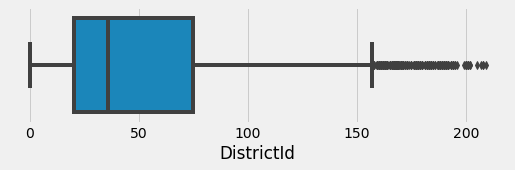


Количество пропущенных элементов 0
median - 36.0
mean - 50.4008
mode - 27

0       48
1      652
2       78
3       82
4       11
      ... 
202      2
205      1
207      1
208      2
209      1
Name: DistrictId, Length: 205, dtype: int64

Количество уникальных элементов 205


In [7]:
#DistrictId - идентификационный номер района
index = 'DistrictId'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 205 уникальных значений в котором есть небольшое количество выбросов, думаю я их так и оставлю в неизменном состоянии. Так как это скорее всего какой-то пригород и попал в выборку случайно.*

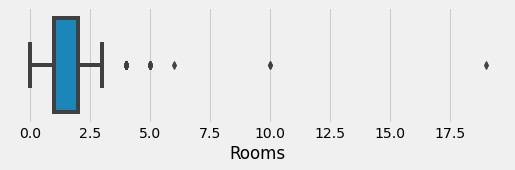


Количество пропущенных элементов 0
median - 2.0
mean - 1.8905
mode - 2.0

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

Количество уникальных элементов 9


In [8]:
#Rooms - количество комнат
index = 'Rooms'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Имеем 9 уникальных значений. Здесь есть странные значения такие как 0(скорее всего это складские помещения или студии) и 10-19(ну это какие-то замки), присвоим им значение min = 1 и max = 5.*

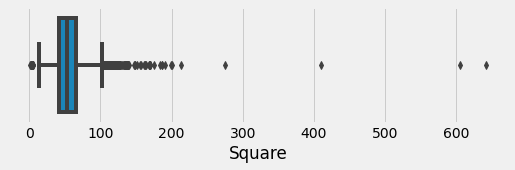


Количество пропущенных элементов 0
median - 52.51330992401352
mean - 56.31577519793557
mode - 1.1368587776514651

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932361    1
275.645284    1
409.425181    1
604.705972    1
641.065193    1
Name: Square, Length: 10000, dtype: int64

Количество уникальных элементов 10000


In [9]:
#Square - площадь
index = 'Square'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь все элементы уникальны, будем их группировать, округляя значения к целому. И имеем немного странных значений в 1-10 кв.м. ну и наши (замки) 600 кв.м. Но из-за незначительного количества прировняем их к моде.*

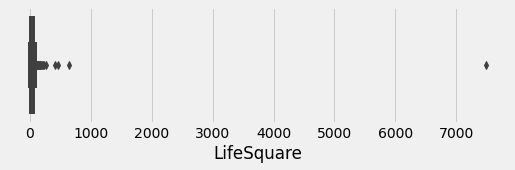


Количество пропущенных элементов 2113
median - nan
mean - 37.199644827673154
mode - nan

0.370619       1
0.641822       1
0.795539       1
0.873147       1
1.049867       1
              ..
263.542020     1
410.639749     1
461.463614     1
638.163193     1
7480.592129    1
Name: LifeSquare, Length: 7887, dtype: int64

Количество уникальных элементов 7887


In [10]:
#LifeSquare - жилая площадь
index = 'LifeSquare'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Ситуация такая, как и в фиче выше.А пропуски заполним по формуле LifeSquare = Square - KitchenSquare- 5% x Square*

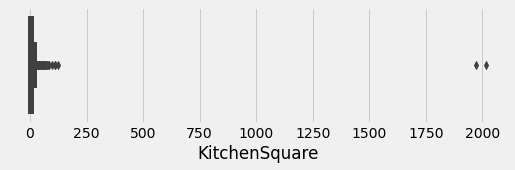


Количество пропущенных элементов 0
median - 6.0
mean - 6.2733
mode - 1.0

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

Количество уникальны

In [11]:
#KitchenSquare - площадь кухни
index = 'KitchenSquare'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Ситуация такая, как и в фиче выше. Треть значений находится в странном диапазоне 0-3 кв.м. В дальнейшем сделаю одну общую фичу из Square, LifeSquare, KitchenSquare, так как они очень сильно положительно коррелированы, путём понижения размерности.*

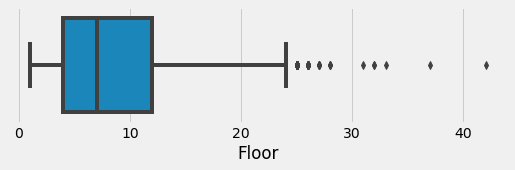


Количество пропущенных элементов 0
median - 7.0
mean - 8.5267
mode - 4

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

Количество уникальных элементов 33


In [12]:
#Floor - этаж
index = 'Floor'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо так что не чего менять не будем.*

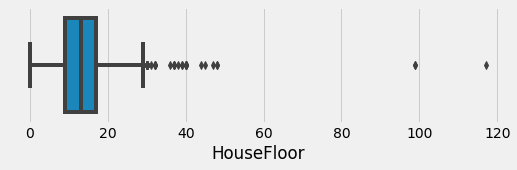


Количество пропущенных элементов 0
median - 13.0
mean - 12.6094
mode - 17.0

0.0       269
1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0       27
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

Количество уникальных элементов 44


In [13]:
#HouseFloor - количество этажей в доме
index = 'HouseFloor'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь есть явные выбросы, это 0 этажность и выше 95 этажа в Москве зданий нет. Нулевые значения прировняем к mode, а значения выше 30 прировняем к 30 этажу.*

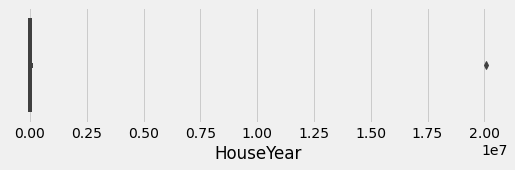


Количество пропущенных элементов 0
median - 1977.0
mean - 3990.1663
mode - 1977

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

Количество уникальных элементов 97


In [14]:
#HouseYear - год постройки дома
index = 'HouseYear'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь есть два странных значения, прировняю их к крайнему значению 2020 так как эти выбросы похожи на ошибку запроса из базы данных. В последствии сделаю более информативную фичу возраст дома ( HouseYear_2 = date.today().year – HouseYear).*

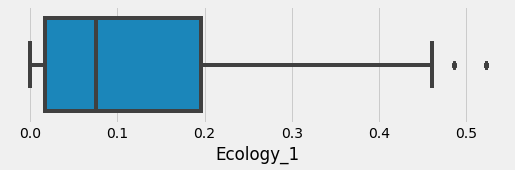


Количество пропущенных элементов 0
median - 0.07542368
mean - 0.11885751885429
mode - 0.007122317

0.000000e+00    537
1.800000e-09     10
6.998930e-05     83
7.815280e-05    245
1.696760e-04     70
               ... 
4.378852e-01    137
4.581745e-01     67
4.605564e-01     31
4.862456e-01     22
5.218671e-01     39
Name: Ecology_1, Length: 129, dtype: int64

Количество уникальных элементов 129


In [15]:
#Ecology_1 - экологические показатели местности
index = 'Ecology_1'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо так что не чего менять не будем.*

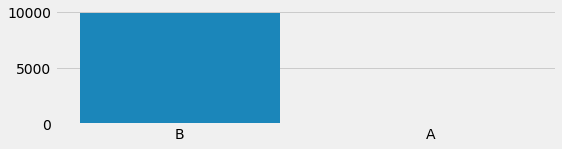


Количество пропущенных элементов 0
A      97
B    9903
Name: Ecology_2, dtype: int64

Количество уникальных элементов 2


In [16]:
#Ecology_2 - экологические показатели местности
index = 'Ecology_2'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Практически все здания относится к классу B. Делаю вывод о бесполезности фичи.*

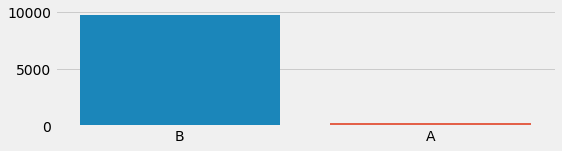


Количество пропущенных элементов 0
A     275
B    9725
Name: Ecology_3, dtype: int64

Количество уникальных элементов 2


In [17]:
#Ecology_3 - экологические показатели местности
index = 'Ecology_3'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Ситуация такая, как и в фиче выше.*

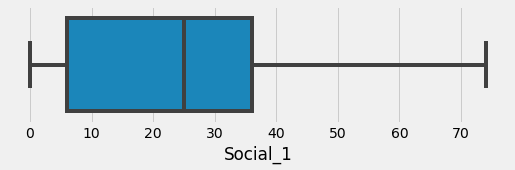


Количество пропущенных элементов 0
median - 25.0
mean - 24.687
mode - 2

0     201
1     654
2     688
3       9
4     141
5     528
6     377
7      15
8      62
9     213
10     24
11    138
12     18
13     22
14     46
15     51
16    123
17     96
18     92
19    118
20     50
21    207
22    367
23    434
24    205
25    557
26    127
27    151
28    144
29     70
30    465
31    243
32     87
33    252
34    311
35    200
36    209
37    205
38     64
39    159
41     83
42    129
43    238
46    245
47    177
49     95
50     79
52    201
53    355
66     99
74    176
Name: Social_1, dtype: int64

Количество уникальных элементов 51


In [18]:
#Social_1 - социальные показатели местности
index = 'Social_1'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо так что не чего менять не будем.*

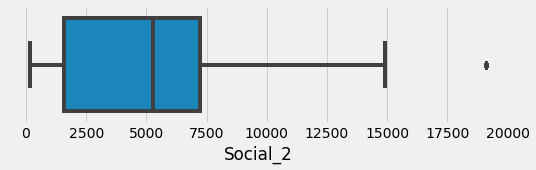


Количество пропущенных элементов 0
median - 5285.0
mean - 5352.1574
mode - 264

168      190
186       11
264      587
290       11
388       56
        ... 
11395     95
12238     79
13670    204
14892    151
19083    176
Name: Social_2, Length: 142, dtype: int64

Количество уникальных элементов 142


In [19]:
#Social_2 - социальные показатели местности
index = 'Social_2'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Ситуация такая, как и в фиче выше.*

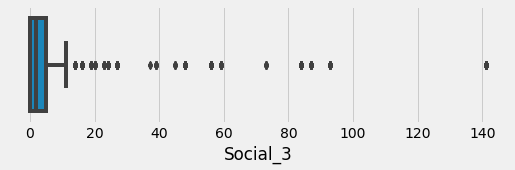


Количество пропущенных элементов 0
median - 2.0
mean - 8.0392
mode - 0

0      2997
1      1861
2       635
3      1136
4       835
5       391
6       423
7       184
8       170
9       192
10      142
11      172
14       97
16      101
19       22
20       19
23       18
24       37
27       59
37        3
39       15
45        9
48       58
56       49
59       25
73       10
84       43
87       27
93       25
141     245
Name: Social_3, dtype: int64

Количество уникальных элементов 30


In [20]:
#Social_3 - социальные показатели местности
index = 'Social_3'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Ситуация такая, как и в фиче выше.*

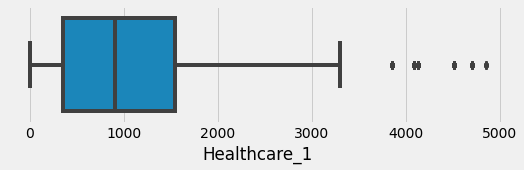


Количество пропущенных элементов 4798
median - nan
mean - 1142.9044598231449
mode - nan

0.0         1
30.0      348
32.0       12
35.0        2
46.0       49
         ... 
4087.0     45
4129.0     37
4508.0     46
4702.0     27
4849.0     15
Name: Healthcare_1, Length: 79, dtype: int64

Количество уникальных элементов 79


In [21]:
#Healthcare_1 - показатели местности, связанные с охраной здоровья
index = 'Healthcare_1'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Практически 50% пропущенных значений, попробуем восстановить по признаку района*

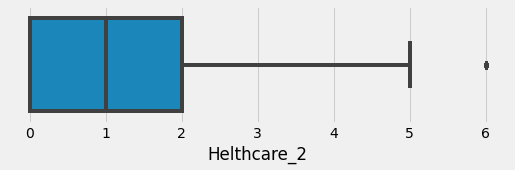


Количество пропущенных элементов 0
median - 1.0
mean - 1.3195
mode - 0

0    4214
1    2183
2    1158
3    1670
4     288
5     388
6      99
Name: Helthcare_2, dtype: int64

Количество уникальных элементов 7


In [22]:
#Helthcare_2 - показатели местности, связанные с охраной здоровья
index = 'Helthcare_2'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо так что не чего менять не будем.*

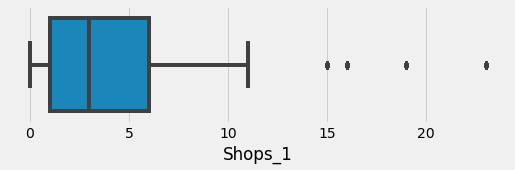


Количество пропущенных элементов 0
median - 3.0
mean - 4.2313
mode - 0

0     2316
1     1325
2      964
3      711
4      841
5     1324
6      487
7      294
8      253
9      316
10     215
11     401
15     176
16      83
19      49
23     245
Name: Shops_1, dtype: int64

Количество уникальных элементов 16


In [23]:
#Shops_1 - показатели, связанные с наличием магазинов, торговых центров
index = 'Shops_1'
plt.figure(figsize=(8, 2))
sns.boxplot(df_train[index], whis=1.5)
plt.xlabel(index)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(f'median - {np.quantile(df_train[index], q=0.5)}\nmean - {np.mean(df_train[index])}\nmode - {stats.mode(df_train[index])[0][0]}\n')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Здесь всё хорошо так что не чего менять не будем.*

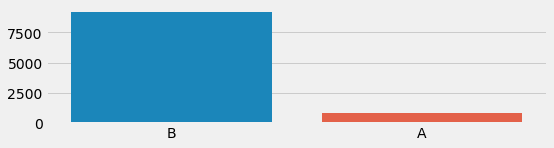


Количество пропущенных элементов 0
A     825
B    9175
Name: Shops_2, dtype: int64

Количество уникальных элементов 2


In [24]:
#Shops_2 - показатели, связанные с наличием магазинов, торговых центров
index = 'Shops_2'
counts = df_train[index].value_counts()
plt.figure(figsize=(8, 2))
sns.barplot(counts.index, counts.values)
plt.show()

print(f'\nКоличество пропущенных элементов {df_train[index].isnull().sum()}')
print(df_train[index].value_counts().sort_index(ascending=True))
print(f'\nКоличество уникальных элементов {df_train[index].value_counts().size}')

### *Практически все здания относится к классу B. Делаю вывод о бесполезности фичи.*

## Исследование целевой переменной
### Построим график распределения целевой переменной "Price" - стоимости квартир

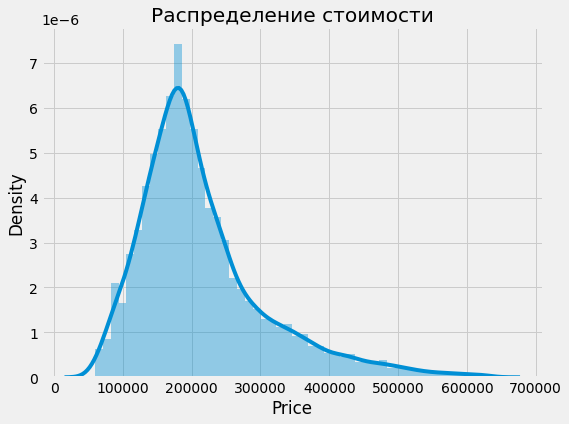

In [25]:
plt.figure(figsize = (8, 6))
sns.distplot(df_train['Price'])
plt.title('Распределение стоимости')
plt.show()

### *Вывод: плотность распределения целевой переменной - нормальная. Большинство квартир встречаются в среднем ценовом диапазоне, по мере увеличения стоимости жилья распределение падает.*

## Обработка данных и создание новых фич

In [26]:
class DataPreprocessing():
    def __init__(self):
        self.rooms_max = None
        self.rooms_min = None
        self.square_mode = None
        self.housefloor_mode = None

        self.districts_healthcare = None
        self.medians = None
        
    def fit(self, df):
        df = df.copy()
        self.medians = df.median()
        self.rooms_max = np.quantile(df['Rooms'], q=0.999)
        self.rooms_min = np.quantile(df['Rooms'], q=0.1)
        
        # Округляем значения к целому.
        df['Square'] = np.round_(df['Square'], decimals = 0)
        self.square_mode = stats.mode(df['Square'])[0][0]
        self.housefloor_mode = stats.mode(df['Floor'])[0][0]

        # Вычислите среднее значение Helthcare_1 в каждом районе
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        
    def transform(self, df):
        df = df.copy()
        # Обработаем выбросы и нулевые значения комнат
        df.loc[df['Rooms'] < 1, 'Rooms'] = self.rooms_min
        df.loc[df['Rooms'] > 5, 'Rooms'] = self.rooms_max
        
        # Округляем значения к целому. Уберем объекты площадью меньше 10 и больше 150.
        df['Square'] = np.round_(df['Square'], decimals = 0)
        df.loc[(df['Square'] > 150) | (df['Square'] < 10), 'Square'] = self.square_mode

        # Почистим значения KitchenSquare которые больше Square * 0.5, так как площадь кухни не должна превышать половины общей площади.
        condition = ((df['KitchenSquare'] > (df['Square'] * 0.4)) | (df['KitchenSquare'] < 3))
        df.loc[condition, 'KitchenSquare'] = 0.25 * df.loc[condition, 'Square']
        df['KitchenSquare'] = np.round_(df['KitchenSquare'], decimals = 0)

        # Исправим пропуски LifeSquare = Square - KitchenSquare - 5% * Square
        condition = ((df['LifeSquare'] > df['Square']) | (df['LifeSquare'].isna()) | (df['LifeSquare'] < (0.5 * df['Square'])))
        df.loc[condition, 'LifeSquare'] = df.loc[condition, 'Square'] - df.loc[condition, 'KitchenSquare'] - 0.05 * df.loc[condition, 'Square']
        df['LifeSquare'] = np.round_(df['LifeSquare'], decimals = 0)

        # изменим год постройки на текузий год, если он больше, чем текущая дата
        year = datetime.now().year
        df.loc[(df['HouseYear'] > year), 'HouseYear'] = year
        
        # обработаем нулевые этажи
        df.loc[(df['HouseFloor'] < 1), 'HouseFloor'] = self.housefloor_mode
        # Уберем выбросы из наблюдений, где этажность больше 95.
        df.loc[(df['HouseFloor'] > 95), 'HouseFloor'] = 95
        # обработаем ситуацию когда этаж больше этажности
        df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloor'] = df.loc[(df['Floor'] > df['HouseFloor']),'Floor']

        # Заполним средними значениями по районам, если отсутствует то заполним средним по диапазону.  
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Ограничим сверху квантилем 
        q_max = np.quantile(df['Healthcare_1'], q=0.95)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)

        # удаляем лишнее
        df.drop(['Ecology_2','Ecology_3','Shops_2', 'Id'], axis=1, inplace=True)

        return df

In [27]:
class FeatureGenetator():
    def __init__(self):
        self.scaler = None
        self.pca_Social = None
        self.pca_Floor = None 
        self.pca_Square = None  
        self.square_max = None
        self.house_year_max = None
        self.scaler = RobustScaler()
        self.pca_Social = PCA(n_components=1, random_state=42)
        self.pca_Floor = PCA(n_components=1, random_state=42)
        self.pca_Square = PCA(n_components=1, random_state=42)


        self.district_price_per_square = None

        self.value_District = None
        self.Prestige_District = None

    def fit(self, df, y):
        
        df = df.copy()
        df['Price'] = y.values

        self.district_price_per_square = (df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')).to_dict()  
        
        self.value_District = df['DistrictId'].value_counts().to_dict()
        med = df.groupby(['DistrictId'], as_index=False).agg({'median'}).reset_index()
        med.columns = df.columns.tolist()
        med.sort_values('Price').reset_index()
        self.Prestige_District = med['DistrictId'].to_dict()

    def transform(self, df):
        df = df.copy()
        
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        median_district_price_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(median_district_price_square, inplace=True)
        df['DistrictPrice'] = np.round_(df['DistrictPrice'], decimals = 0)

        df['DistrictValue'] = df['DistrictId'].map(self.value_District)
        median_district_price_per_square = df['DistrictValue'].median()
        df['DistrictValue'].fillna(median_district_price_per_square, inplace=True)
        
        df['DistrictPrestige'] = df['DistrictId'].map(self.Prestige_District)
        median_district_prestige = df['DistrictPrestige'].median()
        df['DistrictPrestige'].fillna(median_district_prestige, inplace=True)

        df.drop(['DistrictId'], axis=1, inplace=True)

        return df

    def fit_scale_merge(self, df):
        #Масштабирование
        df = pd.DataFrame(self.scaler.fit_transform(df), columns=df.columns)

        # Объединение
        df['Social'] = self.pca_Social.fit_transform(df[['Social_1', 'Social_2']])
        df['Square'] = self.pca_Square.fit_transform(df[['Square', 'LifeSquare']])
        
        #удаление лишнего
        df.drop(['Social_1', 'Social_2', 'LifeSquare'], axis=1, inplace=True)
        
        return df

    def scale_merge(self, df):
        #Масштабирование
        df = pd.DataFrame(self.scaler.transform(df), columns=df.columns)

        # Объединение 
        df['Social'] = self.pca_Social.transform(df[['Social_1', 'Social_2']])
        df['Square'] = self.pca_Square.transform(df[['Square', 'LifeSquare']])
        
        #удаление лишнего
        df.drop(['Social_1', 'Social_2', 'LifeSquare'], axis=1, inplace=True)
        
        return df


    def square_to_cat(self, X):
        bins = [0, 20, 40, 60, 100, self.square_max]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
        X['square_cat'].fillna(-1, inplace=True) 
        return X

    def year_to_cat(self, X):
        bins = [0, 1940, 1960, 1970, 1975, 1980, 1990, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        return X
    


### *Разбиение на train и test*

In [28]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

X = train_df.drop(columns=['Price'])
y = train_df['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [29]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 15), (3300, 15), (5000, 15))

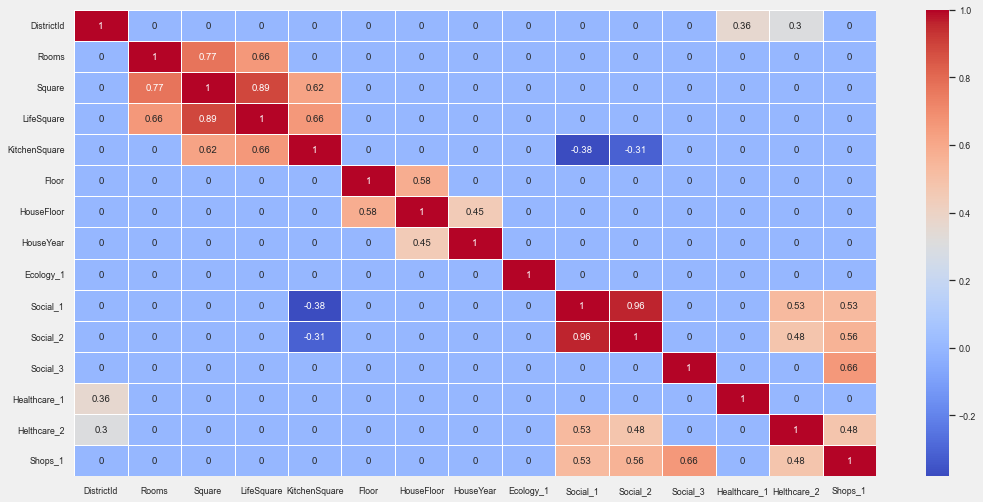

In [30]:
train_df_corr = X_train.corr()
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
train_df_corr_round = np.round(train_df_corr, 2)
train_df_corr_round[np.abs(train_df_corr) < 0.3] = 0
sns.heatmap(train_df_corr_round, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

### *Сильной корреляции между признаками нет, но немного поправим.*

In [31]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)
X_train = features_gen.fit_scale_merge(X_train)
X_valid = features_gen.scale_merge(X_valid)
test_df = features_gen.scale_merge(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 15), (3300, 15), (5000, 15))

In [32]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

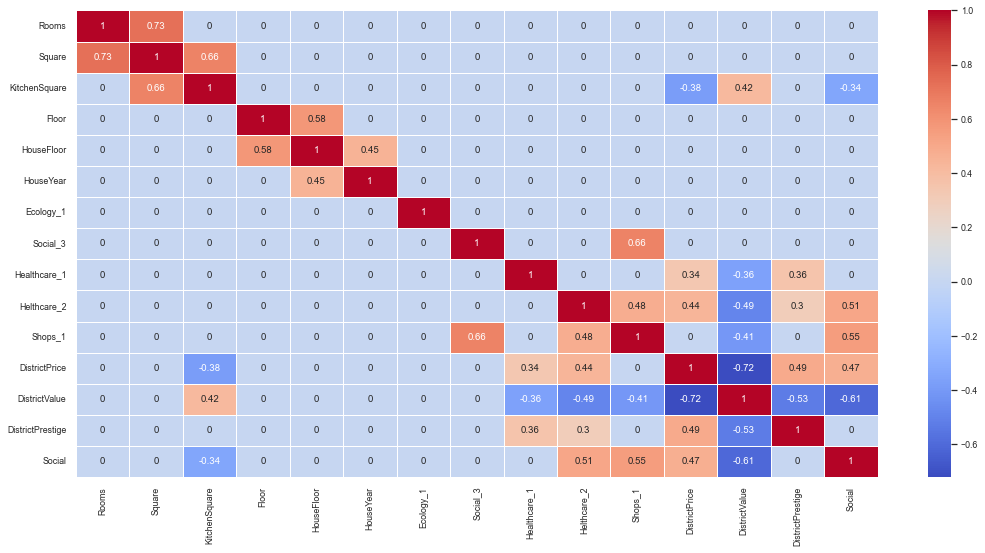

In [33]:
train_df_corr = X_train.corr()
plt.figure(figsize = (16,8))
sns.set(font_scale=0.8)
train_df_corr_round = np.round(train_df_corr, 2)
train_df_corr_round[np.abs(train_df_corr) < 0.3] = 0
sns.heatmap(train_df_corr_round, annot=True, linewidths=.5, cmap='coolwarm')
plt.show()

## Проведём кластеризацию признаков 

TSNE

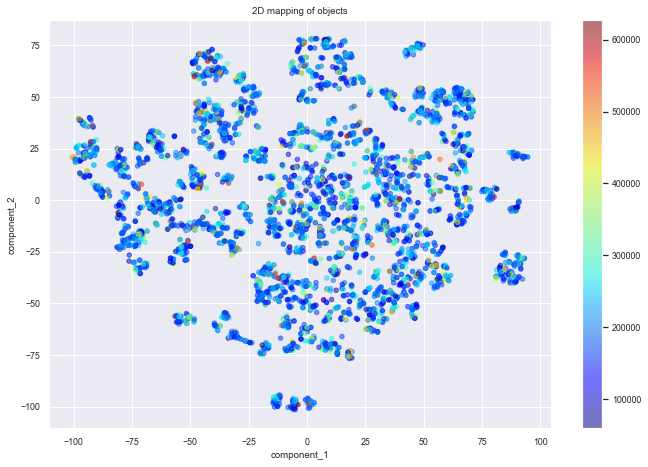

In [34]:
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train, dims=2, method='tsne', perplexity=30)
display_components_in_2D_space(components_2d_tsne, y_train)

PCA

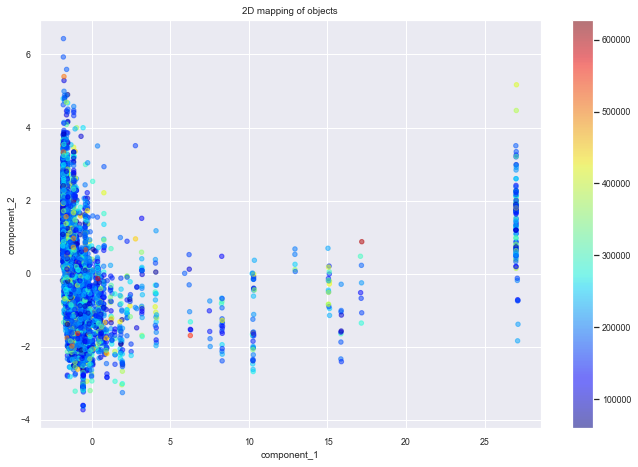

In [35]:
dim_reducer2d, components_2d = reduce_dims(X_train, dims=2, method='pca')
display_components_in_2D_space(components_2d, y_train)

### Кластеризация: k-means

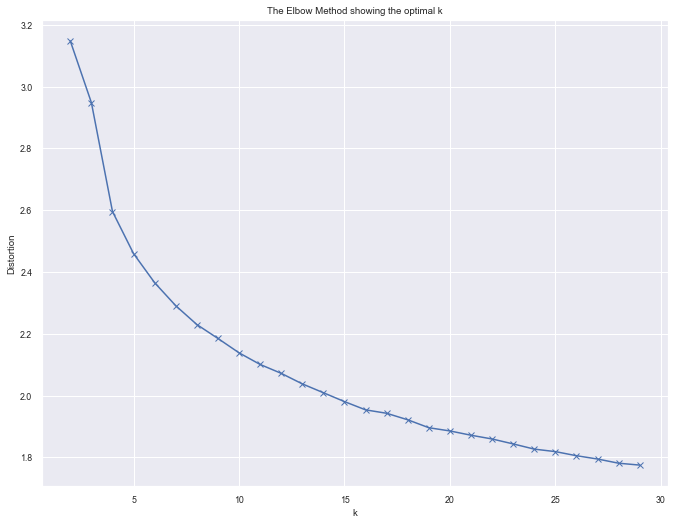

In [36]:
apply_elbow_method(X_train)

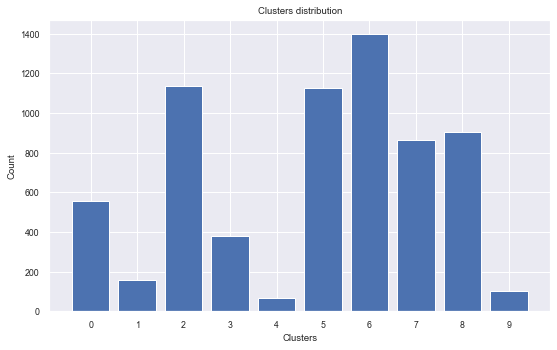

In [37]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels_clast_train_KMeans = kmeans.fit_predict(X_train)
labels_clast_train_KMeans = pd.Series(labels_clast_train_KMeans, name='KMeans')

labels_clast_valid_KMeans = kmeans.predict(X_valid)
labels_clast_valid_KMeans = pd.Series(labels_clast_valid_KMeans, name='KMeans')
labels_clast_test_KMeans = kmeans.predict(test_df)
labels_clast_test_KMeans = pd.Series(labels_clast_test_KMeans, name='KMeans')

unique, counts = np.unique(labels_clast_train_KMeans, return_counts=True)
display_clusters_distribution(unique, counts)

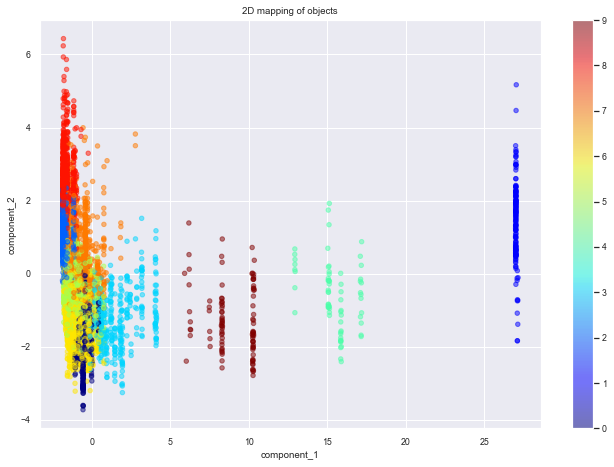

In [38]:
display_components_in_2D_space(components_2d, labels_clast_train_KMeans)

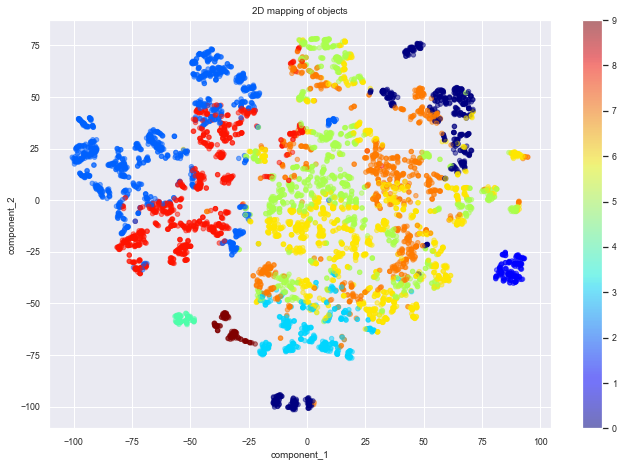

In [39]:
display_components_in_2D_space(components_2d_tsne, labels_clast_train_KMeans)

### Кластеризация: Иерархическая

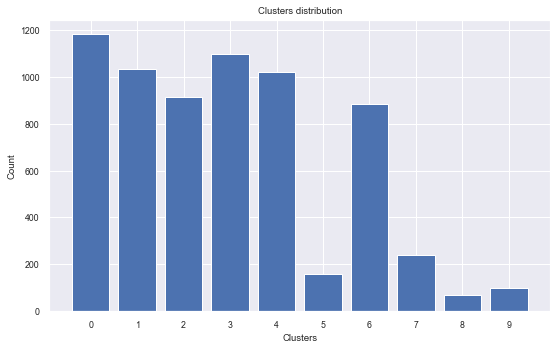

In [40]:
agg = AgglomerativeClustering(n_clusters=10)
labels_clast_agg = agg.fit_predict(X_train)
labels_clast_agg = pd.Series(labels_clast_agg, name='clusters_agg')

unique, counts = np.unique(labels_clast_agg, return_counts=True)
display_clusters_distribution(unique, counts)

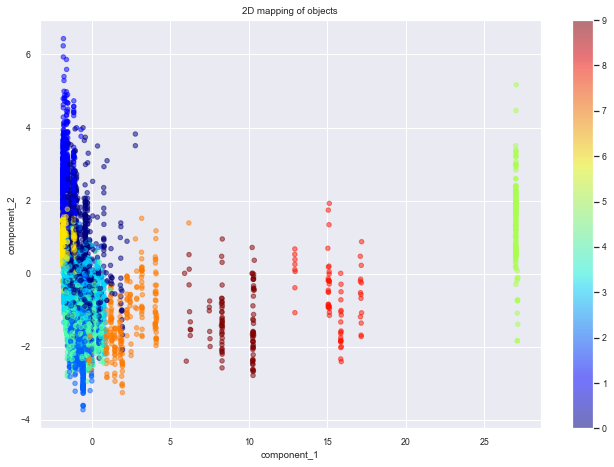

In [41]:
display_components_in_2D_space(components_2d, labels_clast_agg)

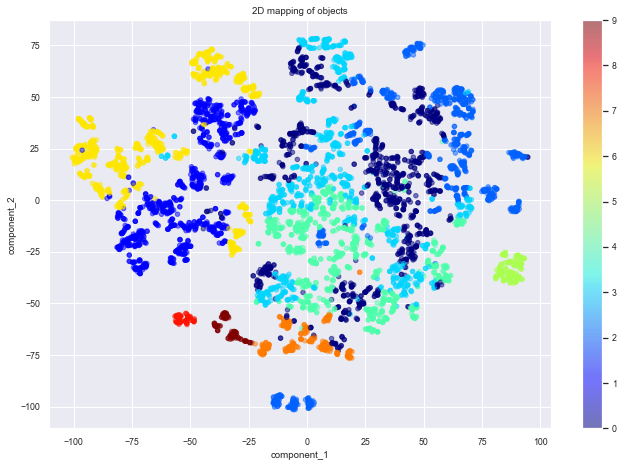

In [42]:
display_components_in_2D_space(components_2d_tsne, labels_clast_agg)

In [43]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, labels_clast_agg)

labels_clast_train_knn = knn.predict(X_train)
labels_clast_train_knn = pd.Series(labels_clast_train_knn, name='clusters_knn')
labels_clast_valid_knn = knn.predict(X_valid)
labels_clast_valid_knn = pd.Series(labels_clast_valid_knn, name='clusters_knn')
labels_clast_test_knn = knn.predict(test_df)
labels_clast_test_knn = pd.Series(labels_clast_test_knn, name='clusters_knn')


### Добавление новых признаков

In [44]:
labels_clast_train_knn = pd.get_dummies(labels_clast_train_knn, prefix='clusters_knn')
labels_clast_valid_knn = pd.get_dummies(labels_clast_valid_knn, prefix='clusters_knn')
labels_clast_test_knn = pd.get_dummies(labels_clast_test_knn, prefix='clusters_knn')
labels_clast_train_KMeans = pd.get_dummies(labels_clast_train_KMeans, prefix='clusters_KMeans')
labels_clast_valid_KMeans = pd.get_dummies(labels_clast_valid_KMeans, prefix='clusters_KMeans')
labels_clast_test_KMeans = pd.get_dummies(labels_clast_test_KMeans, prefix='clusters_KMeans')

X_train_clast = pd.concat([X_train, labels_clast_train_knn, labels_clast_train_KMeans], axis=1)
X_valid_clast = pd.concat([X_valid, labels_clast_valid_knn, labels_clast_valid_KMeans], axis=1)
test_df_clast = pd.concat([test_df, labels_clast_test_knn, labels_clast_test_KMeans], axis=1)
X_train_clast.shape, X_valid_clast.shape, test_df_clast.shape

((6700, 35), (3300, 35), (5000, 35))

### *Построение модели*

In [45]:
rf_clast_1 = RandomForestRegressor(random_state=42,max_depth=20,min_samples_leaf=3,n_estimators=80)
rf_clast_2 = GradientBoostingRegressor(random_state=42,max_depth=2,min_samples_leaf=2,n_estimators=700)
rf_clast_3 = GradientBoostingRegressor(random_state=42,max_depth=6,min_samples_leaf=2,n_estimators=60)
rf_clast_4 = GradientBoostingRegressor(random_state=42, max_depth=3, min_samples_leaf=3, n_estimators=500)
rf_clast_5 = GradientBoostingRegressor(random_state=42, max_depth=6, min_samples_leaf=5, n_estimators=50)

Train R2:	0.85298
Train MAE:	20837.781515
Train MSE:	1224875578.543176

Test R2:	0.696382
Test MAE:	30824.532758
Test MSE:	2797006841.965524


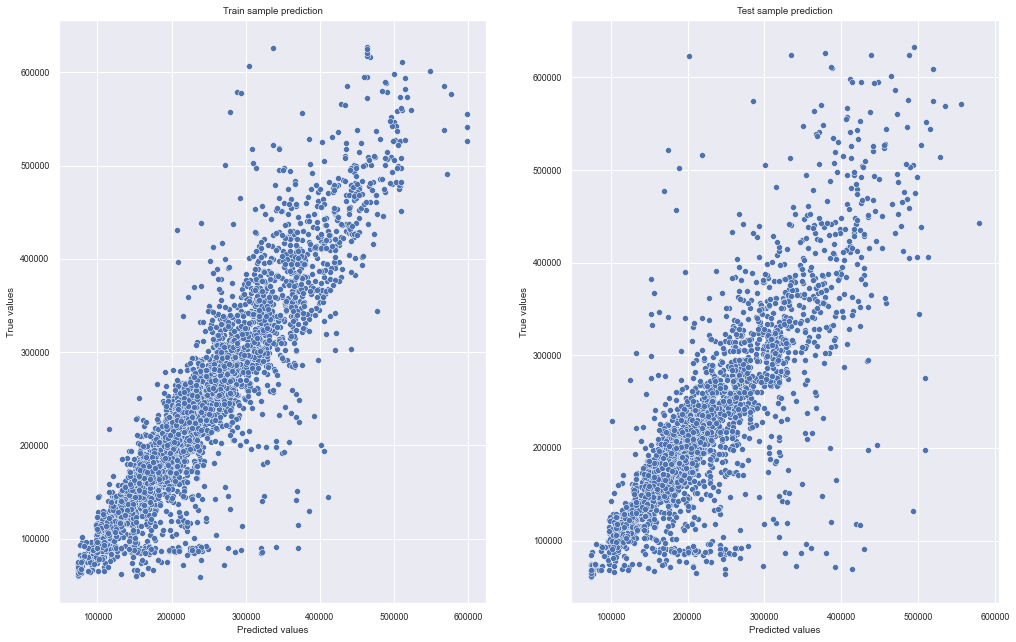

In [46]:
stack_clast = StackingRegressor(
                         [('rf_1', rf_clast_1),
                         ('rf_2', rf_clast_2),
                         ('rf_3', rf_clast_3),
                         ('rf_4', rf_clast_4),
                         ('rf_5', rf_clast_5),
                         ],
                         cv=5,
                         n_jobs=-1,
                         final_estimator=GradientBoostingRegressor(random_state=42, max_depth=6, min_samples_leaf=5, n_estimators=50)
                         )
stack_clast.fit(X_train_clast, y_train)
y_train_preds = stack_clast.predict(X_train_clast)
y_valid_preds = stack_clast.predict(X_valid_clast)


evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

Train R2:	0.880126
Train MAE:	21205.477865
Train MSE:	998712449.520926

Test R2:	0.685687
Test MAE:	32281.424346
Test MSE:	2895527839.02823


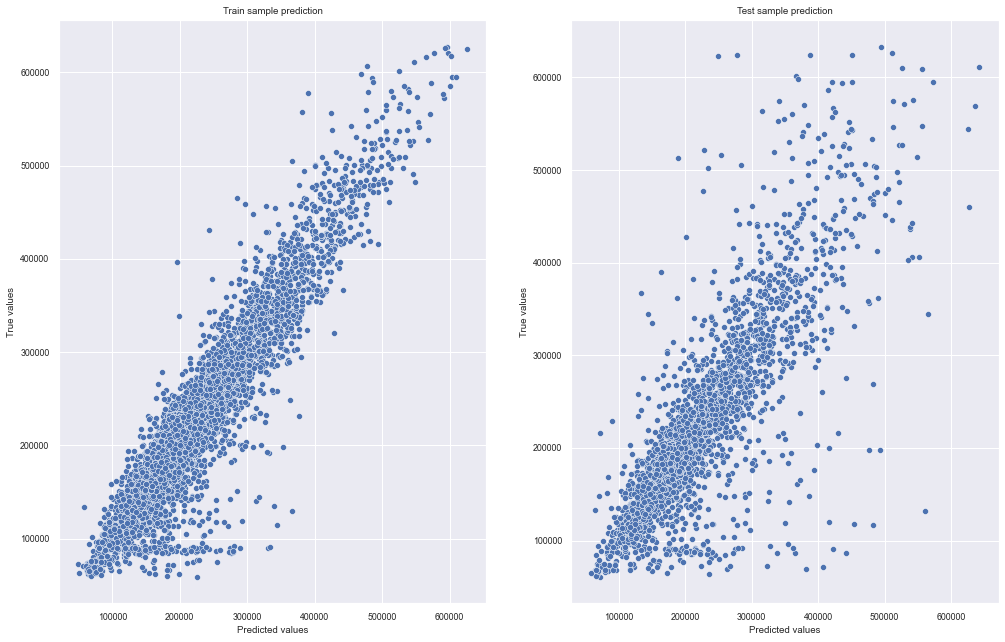

In [51]:
import catboost as catb
stack_clast = catb.CatBoostRegressor(silent=True, iterations=650, depth=2, learning_rate=1, loss_function='RMSE', random_strength=50)
stack_clast.fit(X_train_clast, y_train)
y_train_preds = stack_clast.predict(X_train_clast)
y_valid_preds = stack_clast.predict(X_valid_clast)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### *Оценка модели*

### *Кросс-валидация*

In [48]:
cv_score = cross_val_score(stack_clast, X_train_clast, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score.mean()

0.6966403678603598

### Прогнозирование на тестовом датасете

In [49]:
submit = pd.read_csv(SUBMIT_PATH)
y_test_preds = stack_clast.predict(test_df_clast)
submit['Price'] = y_test_preds
submit.head()

,Id,Price
0,4567,171235.577841
1,5925,125742.738205
2,960,155051.118381
3,3848,134049.919644
4,746,187678.278185


In [50]:
submit.to_csv('sample_submission.csv', index=False)